# Machine Learning & Regression linéaire - Python  
sources:  
https://blog.nalo.fr/lexique/r-carre-ou-r2/  
https://machinelearnia.com/regression-lineaire-equations-normales/  
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html  


## Utilisation des librairies suivantes: numpy, pandas, matplotlib, seaborn, scipy


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import cm



## 1 - Lecture du fichier d'entrée:
On utilise Pandas pour récupérer les données des voitures  
On crée un DataFrame pour simplifier la gestion des données en Python du fichier csv

In [2]:
df = pd.read_csv("data/carData.csv")
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


## 2 Quelques conversions dans le DataFrame :
Avant de traiter les données on peut les normaliser/standardiser  
Ici on se contentera notamment de remplacer les valeurs catégoriques en valeurs numériques

In [3]:
df = df.replace("Petrol", 0).replace("Diesel", 1).replace("CNG", 2)
df = df.replace("Manual", 0).replace("Automatic", 1)
df["Year"] = 2020 - df["Year"]
df["Kms_Driven"] = 1/(df["Kms_Driven"] / 10**3)



## 3, 4 - Visualisation des stats de base :
Analyses élémentaires des données: distributions, corrélations, stats

In [4]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Transmission,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,6.372093,4.661296,7.628472,0.084670,0.212625,0.132890,0.043189
std,2.891554,5.082812,8.644115,0.199740,0.425801,0.340021,0.247915
min,2.000000,0.100000,0.320000,0.002000,0.000000,0.000000,0.000000
25%,4.000000,0.900000,1.200000,0.020506,0.000000,0.000000,0.000000
50%,6.000000,3.600000,6.400000,0.031250,0.000000,0.000000,0.000000
75%,8.000000,6.000000,9.900000,0.066667,0.000000,0.000000,0.000000
max,17.000000,35.000000,92.600000,2.000000,2.000000,1.000000,3.000000


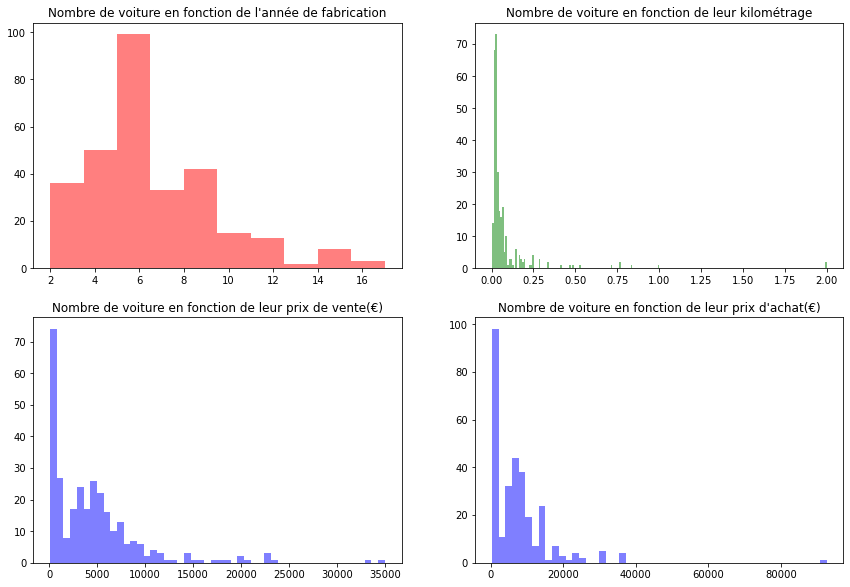

In [5]:
nb_echantillon = df.shape[0]
fig, ax = plt.subplots(2,2)
plt.subplots_adjust(left=None, bottom=None, right=2, top=2, wspace=None, hspace=None)
ax[0][0].hist(df["Year"], alpha = 0.5, color = 'r')
ax[0][1].hist(df["Kms_Driven"], bins=200, alpha=0.5, color='g')
ax[1][0].hist(df["Selling_Price"]*1000, bins=50, alpha = 0.5, color = 'b')
ax[1][1].hist(df["Present_Price"]*1000, bins=50, alpha=0.5, color='b')

ax[0][0].title.set_text("Nombre de voiture en fonction de l'année de fabrication")
ax[0][1].title.set_text("Nombre de voiture en fonction de leur kilométrage")
ax[1][0].title.set_text("Nombre de voiture en fonction de leur prix de vente(€)")
ax[1][1].title.set_text("Nombre de voiture en fonction de leur prix d'achat(€)")
plt.show()

Une voiture moyenne aura 7 ans, un prix de vente de 5.000€ et environs 70.000km au compteur  

### Corrélations entres les différentes colonnes du Dataset :
On utilise la matrice de corrélation de Pandas et la méthode heatmap de seaborn  
Les couleurs chaudes/froides indiquent une corrélation forte et le blanc indique le contraire  

<AxesSubplot:>

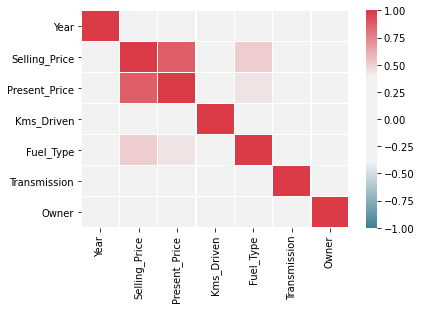

In [6]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True, sep=100), vmin=-1, vmax=1, center=0, linewidths=.5)

### catplot utilisé pour visualiser la relation entre plusieurs variables  
Prix de vente en fonction de l'année et de la transmission de la voiture  

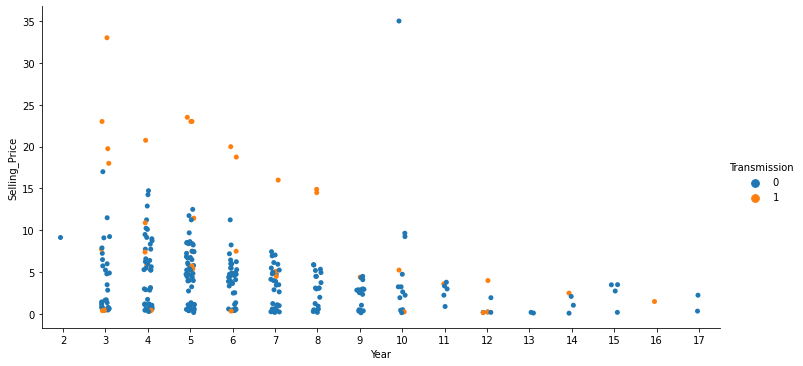

In [7]:
sns.catplot(x="Year", y="Selling_Price", hue="Transmission", data=df, height=5, aspect=2)
plt.show()

### Dispersion des prix de vente avec violinplot de seaborn:

<AxesSubplot:xlabel='Selling_Price'>

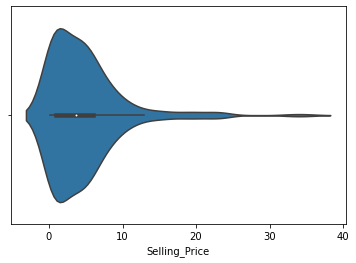

In [8]:
sns.violinplot(x=df["Selling_Price"])

### jointplot de seaborn :

Permet une analyse un peu plus poussée qu'un simple plot entre deux variables  
Distribution des deux axes, tendance   

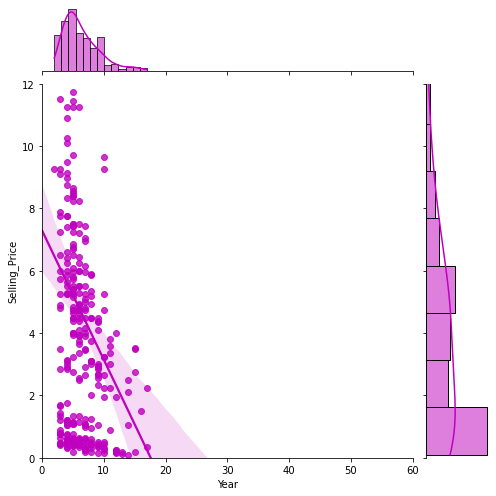

In [9]:
sns.jointplot(x="Year", y="Selling_Price", data=df[["Selling_Price", "Year"]],
                  kind="reg", truncate=False,
                  xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)



## 5 - Régression Linéaire :
### Quantifions la relation entre le prix et l'année de vente

On constate que le prix de vente est un peu corrélé avec l'age de la voiture.
On peut penser qu'une regression linéaire pourrait nous permettre de faire des estimations de prix à partir de ce Dataset.  
On aurait donc une fonction de type ax + b et on cherche à connaitre les paramètres a et b pour lesquelles il y'a le moins d'erreur sur l'ensemble des points.  
3 implémentations : numpy, sklearn, scipy  
  
Afin de juger la véracité des modèles on pourra calculer le coefficient de détermination R carré

In [10]:
# Utilisé pour le calcul de r2
from sklearn.metrics import r2_score

#### Déclarations des données concernées

In [11]:
# x => Années
# y => Prix de vente
# x & y sont les mêmes pour toutes les méthodes univariés
x, y = df["Year"].to_numpy().reshape(nb_echantillon, -1), df["Selling_Price"].to_numpy().reshape(nb_echantillon, -1)



### NumPy  

Les équations normales peuvent nous être utile dans le cas d'une regression linéaire puisque ce nous permet de trouver à la suite d'un calcul les coefficients optimisées pour a et b  

In [12]:
# On redéclare notre vecteur x avec des 1 pour pouvoir effectuer les équations normales
x1 = np.hstack((np.ones(x.shape), x))

# Équations normales
theta = np.linalg.pinv(x1.T.dot(x1)).dot(x1.T).dot(y)

# Paramètre a et b optimisé
f'a={theta[1][0]}, b={theta[0][0]}'

'a=-0.41509169463554646, b=7.306298572461729'

In [13]:
# Produit matriciel qui correspond aux prédictions de notre model
# On calcul toutes les valeurs de y en fonction des paramètres a;b 
y_pred_1 = x1.dot(theta)

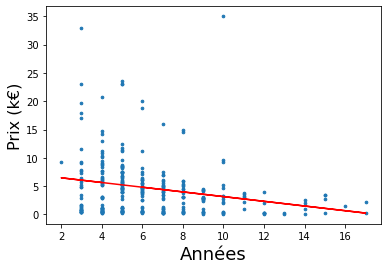

In [14]:
plt.scatter(x, y, s=7)
plt.xlabel('Années', fontsize=18)
plt.ylabel('Prix (k€)', fontsize=16)
plt.plot(x, y_pred_1, c='r')

In [15]:
f'Coefficient R2 = {round(r2_score(y, y_pred_1), 2)}'

'Coefficient R2 = 0.06'

  
  
### SKLearn

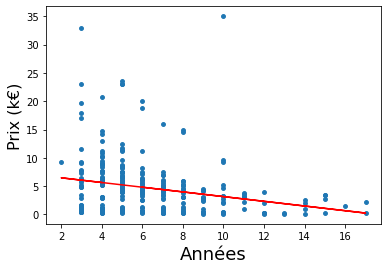

In [16]:
from sklearn.linear_model import LinearRegression

# Nouveau modèle de regression linéaire
model = LinearRegression()
# On améliore la véracité de notre model
model.fit(x, y)
# Prédictions y de notre model
y_pred_2 = model.predict(x)

plt.scatter(x, y, s=15)
plt.xlabel('Années', fontsize=18)
plt.ylabel('Prix (k€)', fontsize=16)
plt.plot(x, y_pred_2, c='r')

In [17]:
f'Coefficient R2 = {round(r2_score(y, y_pred_1), 2)}'

'Coefficient R2 = 0.06'



### SciPy


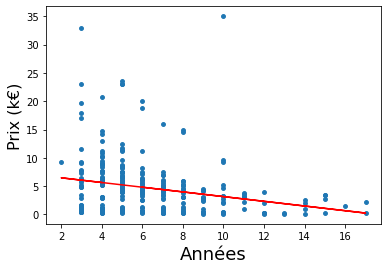

In [18]:
a, b, r, p_value, std_err = stats.linregress(x.flatten(), y.flatten())
theta = b, a
y_pred_3 = x1.dot(theta)

plt.scatter(x, y, s=15)
plt.xlabel('Années', fontsize=18)
plt.ylabel('Prix (k€)', fontsize=16)
plt.plot(x, y_pred_3, c="red")

In [19]:
f'Coefficient R2 = {round(r2_score(y, y_pred_3), 2)}'

'Coefficient R2 = 0.06'

### Amélioration du modèle avec plusieurs variables d'entrée (année, kilométrage, transmission, carburant)

En utilisant 3 méthodes différentes on arrive à chaque fois au même modèle et à un R2 proche des 6%, c'est un résultat très mauvais enfaite : on ne pourra pas vraiment faire d'estimation fiable à partir de ce modèle car elle aura une marge d'erreur trop élevée.  
Pour y remédier on peut essayer de faire un modèle multivarié, càd un modèle à partir de plusieurs variables.  
Ici on rajoute les km parcourus et la transmission de la voiture.

L'implémentation grâce à sklearn est la même en univarié qu'en multivarié, il faut simplement spécifier les colonnes concernées.

In [20]:
model_multivarie = LinearRegression()

x2 = np.array(df[["Year", "Kms_Driven", "Transmission"]])

model_multivarie.fit(x2, y)

predictions_multi = model_multivarie.predict(x2)

f'Coefficient R2 = {round(model_multivarie.score(x2, y), 2)}'

'Coefficient R2 = 0.24'

On constate que le modèle multivariés a une meilleur véracité que le modèle univarié, dans ce cas là il y'a un rapport de 4 entre les deux.  
Selon la corrélation des variables, le coefficient r2 peut rapidement augmenter et on peut arriver à un modèle assez concluant.  
Ici 24% de r2 est toujours faible avec ces 3 variables.




## 6 - Régression Linéraire multivariés perso.

L'implémentation de la régression linéaire multivarié peut se faire à l'aide de la descente de gradient.  
4 étapes à suivre :  
- calcul du nouveau model en fonction de theta -> on récupère toutes les valeurs de y (produit matriciel)  
- fonction de cout -> taux d'erreur du modèle  
- gradient -> calcul de dérivée en fonction de theta  
- descente de gradient -> réassignation d'un nouveau theta  

In [21]:
import Regression as myReg

In [22]:
x_multi = np.array(df[["Year", "Kms_Driven", "Transmission"]])

In [23]:
reg = myReg.Regression(x_multi, y)

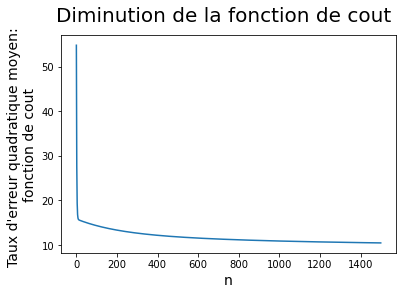

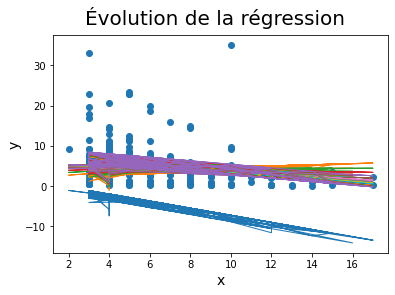

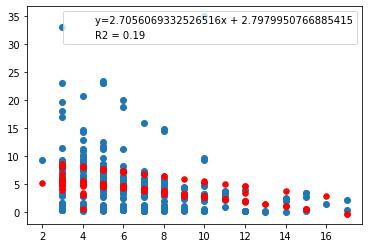

In [24]:
n_iter = 1500
ln_rate = .005

theta, y_pred_4, model_hist, cost_hist = reg.gradient_descent(n_iter, ln_rate)
myReg.Utils.plot_result(x, y, y_pred_4, theta, n_iter, model_hist, cost_hist)



In [25]:
f'Coefficient R2 = {round(r2_score(y, y_pred_4), 2)}'

'Coefficient R2 = 0.19'

On retrouve le même r2 que pour l'implémentation avec sklearn avec les mêmes variables, ce qui signifie que l'algo de descente de gradient fonctionne.  
On remarque aussi que le modèle finale peut énormément changer en fonction du learningRate et du nombre d'itérations.  



## 8 - Estimation du prix d'une voiture en fonction d'un modèle mutlivariés


In [26]:
x_multi_2 = np.array(df[["Present_Price", "Transmission", "Kms_Driven", "Year"]])
reg_2 = myReg.Regression(x_multi_2, y)
theta_2, y_pred_5, model_hist_2, cost_hist_2 = reg_2.gradient_descent(n_iter, ln_rate)
# myReg.Utils.plot_result(x, y, y_pred_5, theta_2, n_iter, model_hist_2, cost_hist_2)
f"r2={round(r2_score(y, y_pred_5), 2)}"

'r2=0.86'

In [27]:
age, km = map(int, input("age km").split(" "))

age km7 60000


In [28]:
input_data = np.array([age, 1/(km/10**3), 0]).reshape(1, -1)

In [29]:
print(f"Caractéristiques de la voiture:\nAge: {age},\nKilomètres: {km},\nTransmission: Manuel")

Caractéristiques de la voiture:
Age: 7,
Kilomètres: 60000,
Transmission: Manuel


In [30]:
f"Estimation du prix de la voiture: {round(model_multivarie.predict(input_data)[0][0]*1000, 2)}€"

'Estimation du prix de la voiture: 3969.31€'



### Visualisation 3D

<IPython.core.display.Javascript object>


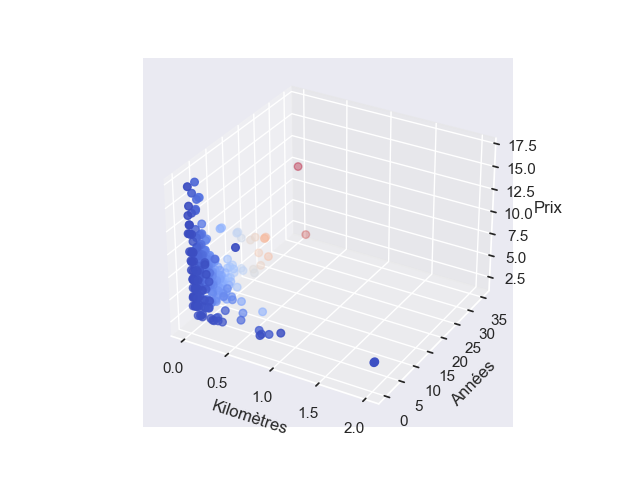

In [31]:
%matplotlib notebook
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
col = np.arange(301)

mx = df["Kms_Driven"]
my = y.flatten()
mz = x.flatten()

ax.set_xlabel("Kilomètres")
ax.set_ylabel("Années")
ax.set_zlabel("Prix")

ax.scatter(mx, my, mz, s=30, c=y, cmap = cm.coolwarm)